# Hello GCN

In [1]:
import numpy as np
import networkx
from matplotlib import pyplot as plt

In [2]:
def ReLU(x):
    return (abs(x) + x) / 2

## GCN 的输入

与传统网络不同的是，$GCN$ 的输入并不只是的特征，它额外包含了图中各个结点之间的关系，那么关系用什么表征呢？显而易见，邻接矩阵是一个非常简单易行的表示方法，这里**使用邻接矩阵 $A$ 来表示各个顶点之间的关系**，显然 $A.shape = (N, N)$

相应地，各个顶点的特征使用矩阵组织起来就好啦，这里使用 $X$ 表示输入层特征矩阵， $H^i$ 表示第 $i$ 隐藏层特征矩阵，当然 $X = H^0$ ，显然 $H^i.shape = (N, F^i)$

> $F^i$ 表示第 $i$ 层的特征维度，$N$ 表示顶点个数

### 与传统网络的联系

很容易发现，$X$ 的组织方式并无不同，只不过额外增加了一个表示关系的邻接矩阵 $A$ 将各个数据联系在了一起，也就是说，原来一个 $batch$ 所有数据没有相关性，而**现在一个 $batch$ 各个数据形成了拓扑联系**，所以我们后续就要在这个关系的基础上进行训练

另外，特征的维度便是传统网络的某一层结点单元数，特征维度的变换便是各层结点之间的全连接，当然这也说明了为何 $W^i.shape = (F^i, F^{i+1})$ ，当然，$W^i$ 的所有参数都用在了两层之间全连接上了，图卷积并无参数（区别于 $CNN$ 卷积核需要参数）

## 图卷积网络层的构建

首先考虑一种非常非常简单的传播方式

$$
H^{i+1} = g(A H^i W^i)
$$

> $g$ 为激活函数，$W^i$ 为第 $i$ 层的参数，$W^i.shape = (F^i, F^{i+1})$，另外值得注意的是，这里的乘法均为矩阵乘法，仅仅看 $shape$ 便可以知道这种变幻的合理性了， $(N, N) \cdot (N, F^i) \cdot (F^i, F^{i+1}) = (N, F^{i+1})$ ，但是究竟为什么这样会有效呢？

下面考虑一个非常简单的示例，图结构如下($N = 4$)，

![GCN_01](../../../docs/Images/GCN_01.png)

首先写出邻接矩阵 $A$ ($shape=(4, 4)$)

In [3]:
A = np.matrix([
        [0, 1, 0, 0],
        [0, 0, 1, 1], 
        [0, 1, 0, 0],
        [1, 0, 1, 0]
    ],dtype=np.float64
)

然后表示输入特征 $X$ ($shape=(4, 2)$) （这里输入特征维度为 $2$）

In [4]:
X = np.matrix([
        [i, -i] for i in range(A.shape[0])
    ], dtype=np.float64)
X

matrix([[ 0.,  0.],
        [ 1., -1.],
        [ 2., -2.],
        [ 3., -3.]])

应用图卷积

In [5]:
A * X

matrix([[ 1., -1.],
        [ 5., -5.],
        [ 1., -1.],
        [ 2., -2.]])

我们可以发现，原始特征在经过第一步图卷积之后在图上发生了传播，比如顶点 1 ，聚合了邻居 2 和 3 的特征

> 如果存在从 $u$ 到 $v$ 的边，则 $v$ 是 $u$ 的邻居，也即有向图沿着箭头的反方向传播，无向图沿着边传播

但是这样就会产生两个问题

- 首先，每个顶点特征在传播后自身的信息会丢失，为了避免这一问题，可以通过**在图上增加自环**来解决，具体方法就是在 $A$ 的基础上增加单位矩阵 $I$ ，得到的修正结果为 $\hat{A}$

In [6]:
I = np.matrix(np.eye(A.shape[0]))
I

matrix([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])

In [7]:
A_hat = A + I
A_hat * X

matrix([[ 1., -1.],
        [ 6., -6.],
        [ 3., -3.],
        [ 5., -5.]])

- 另外还有一个问题就是，各个特征在聚合的过程中传播的次数取决于顶点度的大小，度大的顶点会使得特征的在整体表征所占权重更大，这可能会引发梯度消失或梯度爆炸，一种简单的想法就是**对度进行归一化**，至于归一化的方法，可以使用 $D^{-1} A$ ，论文中使用 $D^{-\frac{1}{2}} A D^{-\frac{1}{2}}$，道理都一样，本文暂时不涉及后者

   > $D$ 为矩阵 $A$ 的度矩阵

   首先写出获取一个矩阵的度矩阵的函数，并求得矩阵 $A$ 的度矩阵 $D$

In [8]:
def get_degree_matrix(A):
    D = np.array(np.sum(A, axis=0))[0]
    D = np.matrix(np.diag(D))
    return D
D = get_degree_matrix(A)
D

matrix([[1., 0., 0., 0.],
        [0., 2., 0., 0.],
        [0., 0., 2., 0.],
        [0., 0., 0., 1.]])

   下面求出归一化的邻接矩阵

In [9]:
D**-1 * A

matrix([[0. , 1. , 0. , 0. ],
        [0. , 0. , 0.5, 0.5],
        [0. , 0.5, 0. , 0. ],
        [1. , 0. , 1. , 0. ]])

   很明显，临界矩阵在度大的方向减小了链接权重（除以对应的度）

In [10]:
D**-1 * A * X

matrix([[ 1. , -1. ],
        [ 2.5, -2.5],
        [ 0.5, -0.5],
        [ 2. , -2. ]])

   相应地，聚合时传播效果也是归一化的结果

下面，将上述两个问题结合起来，首先求得 $\hat{A}$ ，之后对 $\hat{A}$ 进行归一化，当然，$\hat{D}$ 是 $\hat{A}$ 的度矩阵

In [11]:
D_hat = get_degree_matrix(A_hat)
D_hat**-1 * A_hat * X

matrix([[ 0.5, -0.5],
        [ 2. , -2. ],
        [ 1. , -1. ],
        [ 2.5, -2.5]])

至于后面的参数，乘一下就好了，然后加上激活函数便完成一层图卷积网络层了

In [12]:
W = np.matrix([
             [1, -1],
             [-1, 1]
         ])
ReLU(D_hat**-1 * A_hat * X * W)

matrix([[1., 0.],
        [4., 0.],
        [2., 0.],
        [5., 0.]])

## 何谓卷积

回顾传统卷积，可以看做是每个卷积核处，不同像素点的特征聚合于卷积核中心处而已

![GCN_02](../../../docs/Images/GCN_02.png)

而图卷积，是沿着图的边，将邻居的特征聚合于自身

![GCN_03](../../../docs/Images/GCN_03.png)

> 本图为无向图，若为有向图，聚合方向沿着箭头的反方向

当然，前者发生在欧式空间，后者是在拓扑结构上，所谓卷积，可以说是相邻结点的一次信息聚合，而信息的聚合，[Ref3](https://www.zhihu.com/question/54504471)一文中首先使用了温度场模型的热量传播进行比拟，之后推到图模型，由浅及深地进行了解释

> 由于本学期有一门专业课恰好学习并实践温度场模型的有限差分模拟，所以看到这篇文章倍感亲切~

## 图卷积的优点

图卷积是在传统网络的基础上增加了图的结构，增加的信息当然不是毫无用处，因为图的存在，使用随机初始化的参数便可完成初步的聚类，而且只需要较少的标签便可完成学习，因此 $GCN$ 也被称为是一种**半监督学习**方式

## 总结

整个图卷积网络层，可以分为两步，第一步是图卷积，第二步是层与层之间的连接

前者使用邻接矩阵 $A$ ，使得特征沿着图的边进行传播，得到 $A H^i$ ，考虑到自环问题和归一化问题的话，改为 $\hat{D}^{-1} \hat{A} H^i$ 或者 $D^{-\frac{1}{2}} A D^{-\frac{1}{2}} \hat{A} H^i$ 即可

后者使用链接权重 $W^i$ ，与传统网络并无不同，其 $shape$ 依然为 $(f^{in}, f^{out})$ （这里 $in$ 和 $out$ 用来表示层的输入与输出），之后激活一下就好啦

总的来说，图卷积不过是在前层特征计算完之后再整张图上传播一下（第一步），之后和传统网络并无区别，所以说， $GCN$ 也没啥难的嘛~

> 下面是基于空手道俱乐部数据搭建的网络结构

In [13]:
zkc = networkx.karate_club_graph()
order = sorted(list(zkc.nodes()))
A = networkx.to_numpy_matrix(zkc, nodelist=order)
I = np.eye(zkc.number_of_nodes())
A_hat = A + I
D_hat = np.array(np.sum(A_hat, axis=0))[0]
D_hat = np.matrix(np.diag(D_hat))

C:\Software\Anaconda\envs\tensorflow_gpu\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


([], <a list of 0 Text yticklabel objects>)

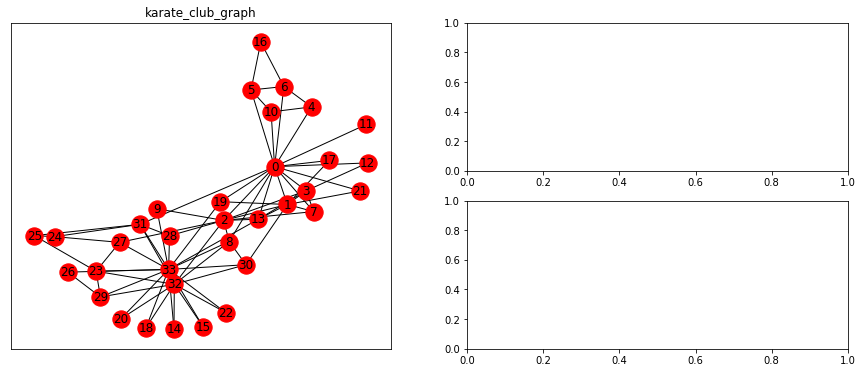

In [14]:
plt.subplots(2,2,figsize=(15,6))
G = networkx.karate_club_graph() 
plt.subplot(1,2,1)
networkx.draw(G, with_labels=True) 
plt.title('karate_club_graph') 
plt.axis('on') 
plt.xticks([]) 
plt.yticks([])

In [15]:
W_1 = np.random.normal(
    loc=0, scale=1, size=(zkc.number_of_nodes(), 4))
W_2 = np.random.normal(
    loc=0, size=(W_1.shape[1], 2))

In [16]:
def gcn_layer(A_hat, D_hat, X, W):
    return ReLU(D_hat**-1 * A_hat * X * W)
H_1 = gcn_layer(A_hat, D_hat, I, W_1)
H_2 = gcn_layer(A_hat, D_hat, H_1, W_2)
output = H_2

In [17]:
feature_representations = {
    node: np.array(output)[node] 
    for node in zkc.nodes()}